In [2]:
import sys
import os
import jax
import jaxlib
print(jax.__version__)
print(jaxlib.__version__)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
os.chdir('../scripts/')
from tqdm import tqdm
from jaxkan.KAN import KAN
import jax.numpy as jnp
from jax_data import SimDataset 
from jax import grad, vmap
from jaxopt.loss import huber_loss

from flax import nnx
import optax
import orbax.checkpoint as ocp

import matplotlib.pyplot as plt
import graphics as gr
import numpy as np
from jaxkan.utils.PIKAN import gradf
from jax_utils import force_1d_parallel

%pylab inline

0.4.35
0.4.34
gpu


/tmp/ipykernel_210251/2626677158.py:8: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [21]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': False})
#plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 15})

In [22]:
# Create a SimData object
n_di = 64
sim_data = SimDataset(n_data_points = 8000*8000, n_pde_a=n_di,key=2, size='adaptdt_seq_custom0.90to3.00')

modeldef = [2, 8, 12, 8, 1]
req_params = {'k': 3, 'G':10, 'grid_e':0.5, 'grid_range':(-0.5, .5),
              'base_basis':0.05, 'base_spline':0.05, 'base_res':0.05,
              'pow_basis':0.5, 'pow_spline':0.5, 'pow_res':0.5}

layer_type = 'spline'
#os.mkdir(outstr)

# Initialize the checkpointer once
# checkpointer = ocp.PyTreeCheckpointer()

seed = 3
model = KAN(layer_dims = modeldef,
            layer_type = layer_type,
            required_parameters = req_params,
            add_bias = True,
            rngs = nnx.Rngs(seed)
           )

['0.90', '3.00']
['0.9', '1', '1.50', '2', '2.50']
dt 0.0005106237746878296
 -- Dataset prepared -- 
a is from 0.90 to 3.00
ic, bc, data and pde shapes are: (8192, 1) (422, 1) (8192, 1)


In [23]:
@nnx.jit
def compute_loss(model, sample):
    def z(x):
        return model(x)
    
    ### ICs
    ic_qa = jnp.stack([jnp.ravel(sample["ic_q"]), jnp.ravel(sample["ic_a"])]).T
    zic = model(ic_qa)
    zic_t = gradf(z,1,1)(ic_qa)
    zic_tt = gradf(z,1,2)(ic_qa)
    loss_ic_z, loss_ic_v, loss_ic_acc = myloss(zic,sample["ic_z"]), myloss(zic_t, sample["ic_v"]), myloss(zic_tt, sample["ic_acc"])
    loss_ic = loss_ic_z + loss_ic_v + loss_ic_acc 

    ### BCs
    bc_qa = jnp.stack([jnp.ravel(sample["bc_q"]), jnp.ravel(sample["bc_a"])]).T
    zbc = model(bc_qa)  # output of u(x,t)
    zbc_t = gradf(z,1,1)(bc_qa)
    zbc_tt = gradf(z,1,2)(bc_qa)
    loss_bc = myloss(zbc, sample["bc_z"]) + myloss(zbc_t, sample["bc_v"]) + myloss(zbc_tt, sample["bc_acc"])

    ### PDE
    this_q = jnp.tile(sample["pde_q"], (1, n_di)).T.ravel().reshape(-1, 1)
    this_z0 = jnp.tile(sample["pde_z0"], (1, n_di)).T.ravel().reshape(-1, 1)
    this_a = sample["pde_a"].T.ravel().reshape(-1, 1)
    
    pde_qa = jnp.stack([this_q.squeeze(), this_a.squeeze()]).T
    
    zpde = model(pde_qa)
    zpde_t = gradf(z,1,1)(pde_qa)
    zpde_tt = gradf(z,1,2)(pde_qa)
    
    x_net_d = this_q + this_z0 + zpde
    
    force1_net_par = force_1d_parallel(
        x_net_d.reshape((n_di, -1, 1)), 
        this_q.reshape((n_di, -1, 1))
    )
    
    force2_net = zpde_tt * this_a ** 2 * 2 / 3 + zpde_t * this_a
    
    #x_net_d = (this_q + this_z0 + zpde).reshape((n_di, -1, 1))
    #pt_q0_d    = -0.5
    #force1_net_par = -jnp.sum(x_net_d > x_net_d.transpose(0,2,1), axis=2, keepdims=True) / 8192 + this_q.reshape((n_di, -1, 1)) - pt_q0_d
    #force2_net = zpde_tt * this_a * this_a * 2 / 3 + zpde_t * this_a - zpde - this_z0

    #print(force1_net_par.shape, force2_net.shape)
    
    #print(force1_net_par.shape, zpde_tt.shape, this_a.squeeze().shape, zpde_t.shape, force2_net.shape)
    mse_pde = myloss(force1_net_par, force2_net.reshape((n_di, -1, 1)))/n_di
    
    loss = loss_ic + loss_bc + mse_pde
    return loss, loss_ic, loss_bc, mse_pde, loss_ic_z, loss_ic_v, loss_ic_acc
# Define train loop
@nnx.jit
def train_step(model, optimizer, sample):

    def loss_fn(model):
        loss, _, _, _, _, _, _ = compute_loss(model, sample)
        return loss

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss



In [24]:
# Setup scheduler for optimizer
scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={0 : 1.0, 2000 :1.0, 4000 : 1.0}
)

opt_type = optax.adam(learning_rate=scheduler)

optimizer = nnx.Optimizer(model, opt_type)

def myloss(x, y):
    #return jnp.mean(huber_loss(x, y))
    return jnp.mean((x - y)**2)

In [25]:
# Initialize train_losses
num_epochs = 2000
log=10
train_losses = jnp.zeros((num_epochs//log,))
ic_losses = jnp.zeros((num_epochs//log,))
ic_z_losses = jnp.zeros((num_epochs//log,))
ic_v_losses = jnp.zeros((num_epochs//log,))
ic_acc_losses = jnp.zeros((num_epochs//log,))
bc_losses = jnp.zeros((num_epochs//log,))
pde_losses = jnp.zeros((num_epochs//log,))
train_dset = iter(sim_data)


In [26]:
pbar = tqdm(range(num_epochs), desc='description', ncols=100)
best_loss = 1e6

for epoch in pbar:
    
    # Calculate the loss
    sample = next(train_dset)
    loss = train_step(model, optimizer, sample)

    # Append the loss
    if epoch % log == 0:
        loss, loss_ic, loss_bc, mse_pde, loss_ic_z, loss_ic_v, loss_ic_acc = compute_loss(model, sample)
        pbar.set_description("loss: %.2e " % (loss))

        train_losses = train_losses.at[epoch//log].set(loss)
        ic_losses = ic_losses.at[epoch//log].set(loss_ic)
        ic_z_losses = ic_z_losses.at[epoch//log].set(loss_ic_z)
        ic_v_losses = ic_v_losses.at[epoch//log].set(loss_ic_v)
        ic_acc_losses = ic_acc_losses.at[epoch//log].set(loss_ic_acc)
        bc_losses = bc_losses.at[epoch//log].set(loss_bc)
        pde_losses = pde_losses.at[epoch//log].set(mse_pde)
    

loss: 1.44e-05 : 100%|██████████████████████████████████████████| 2000/2000 [03:32<00:00,  9.41it/s]


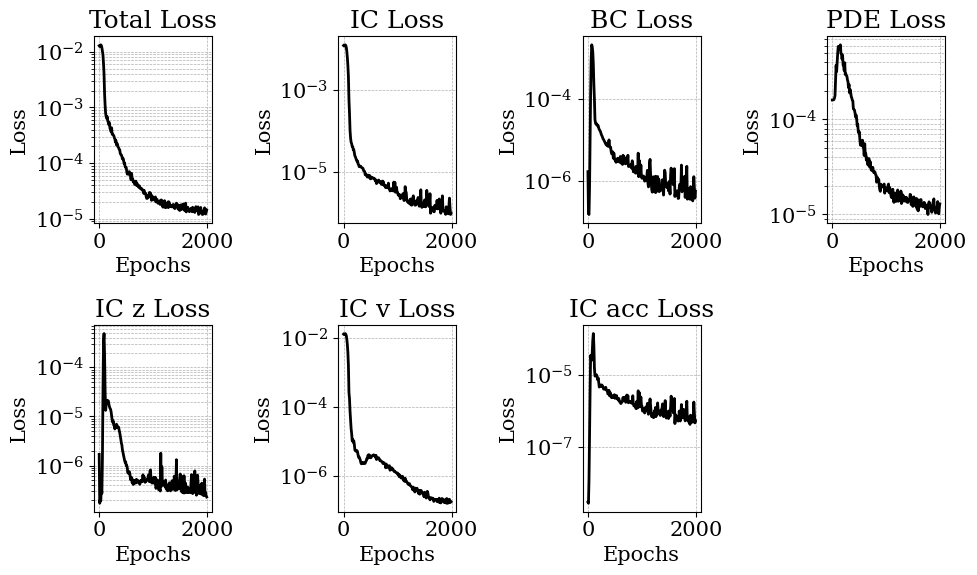

In [27]:
figure(figsize=(10, 6))

subplot(2, 4, 1)
plot(np.arange(0, num_epochs, log), np.array(train_losses), color='k')
xlabel('Epochs')
ylabel('Loss')
title('Total Loss')
yscale('log')
grid(True, which='both', linestyle='--', linewidth=0.5)

subplot(2, 4, 2)
plot(np.arange(0, num_epochs, log), np.array(ic_losses), color='k')
xlabel('Epochs')
ylabel('Loss')
title('IC Loss')
yscale('log')
grid(True, which='both', linestyle='--', linewidth=0.5)

subplot(2, 4, 3)
plot(np.arange(0, num_epochs, log), np.array(bc_losses), color='k')
ylabel('Loss')
title('BC Loss')
yscale('log')
grid(True, which='both', linestyle='--', linewidth=0.5)

subplot(2, 4, 4)
plot(np.arange(0, num_epochs, log), np.array(pde_losses), color='k')
xlabel('Epochs')
ylabel('Loss')
title('PDE Loss')
yscale('log')
grid(True, which='both', linestyle='--', linewidth=0.5)

subplot(2, 4, 5)
plot(np.arange(0, num_epochs, log), np.array(ic_z_losses), color='k')
xlabel('Epochs')
ylabel('Loss')
title('IC z Loss')
yscale('log')
grid(True, which='both', linestyle='--', linewidth=0.5)

subplot(2, 4, 6)
plot(np.arange(0, num_epochs, log), np.array(ic_v_losses), color='k')
xlabel('Epochs')
ylabel('Loss')
title('IC v Loss')
yscale('log')
grid(True, which='both', linestyle='--', linewidth=0.5)

subplot(2, 4, 7)
plot(np.arange(0, num_epochs, log), np.array(ic_acc_losses), color='k')
xlabel('Epochs')
ylabel('Loss')
title('IC acc Loss')
yscale('log')
grid(True, which='both', linestyle='--', linewidth=0.5)
tight_layout()

In [28]:
sample = next(train_dset)

def z(x):
    return model(x)

this_q = jnp.tile(sample["pde_q"], (1, n_di)).T.ravel().reshape(-1, 1)
this_z0 = jnp.tile(sample["pde_z0"], (1, n_di)).T.ravel().reshape(-1, 1)
this_a = sample["pde_a"].T.ravel().reshape(-1, 1)
    
pde_qa = jnp.stack([this_q.squeeze(), this_a.squeeze()]).T
    
zpde = model(pde_qa)
zpde_t = gradf(z,1,1)(pde_qa)
zpde_tt = gradf(z,1,2)(pde_qa)
    
x_net_d = this_z0+zpde + this_q

In [29]:
x_net_d = x_net_d.reshape((n_di, -1, 1))
this_q = this_q.reshape((n_di, -1, 1))
this_z0 = this_z0.reshape((n_di, -1, 1))
zpde_t = zpde_t.reshape((n_di, -1, 1))
zpde_tt = zpde_tt.reshape((n_di, -1, 1))
zpde = zpde.reshape((n_di, -1, 1))
this_a = this_a.reshape((n_di, -1, 1))

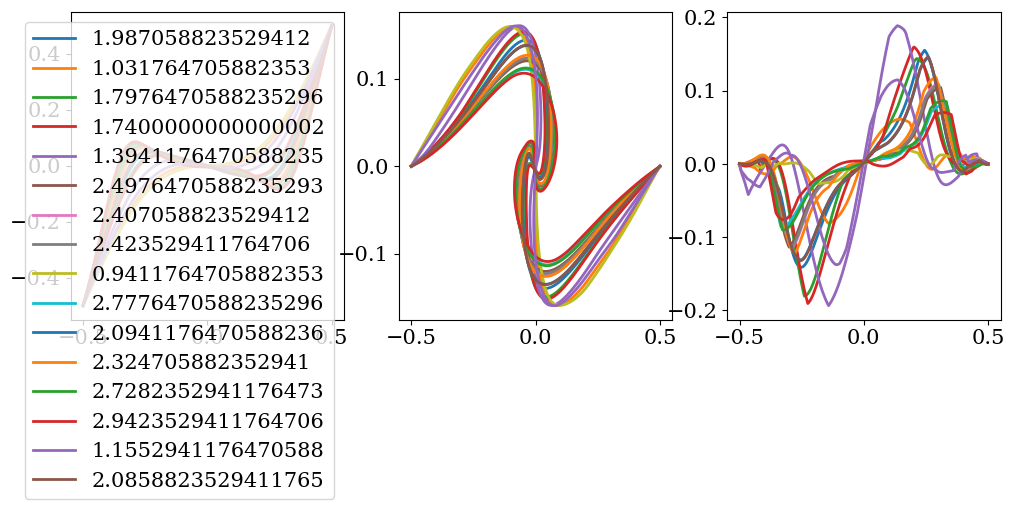

In [30]:
figure(figsize=(12,4))
subplot(131)
for i in range(n_di)[::4]:
    plot(this_q[i], x_net_d[i], label = this_a[i,0,0])
legend()
subplot(132)
for i in range(n_di)[::4]:
    plot(x_net_d[i], zpde_t[i], label = this_a[i,0,0])
subplot(133)
for i in range(n_di)[::4]:
    plot(this_q[i], zpde_tt[i], label = this_a[i,0,0])